# AfriMed-QA: Performance Analysis & Localization Costs

**Key Finding**: LLMs show significant accuracy gaps when moving from USMLE-style to African medical contexts, with pediatric and infectious disease specialties posing particular challenges due to localization requirements.

## Quick Stats

| Metric | Value |
|--------|-------|
| **Total Questions** | 15,275 |
| **Countries** | 16 African nations |
| **Specialties** | 32 medical specialties |
| **Question Types** | MCQ, SAQ, Consumer Queries |
| **Expert Tier** | 4,269 questions |
| **Crowdsourced Tier** | 10,006 questions |

## Analysis Structure

This notebook follows a systematic evaluation framework:

1. **Data Audit** - Dataset quality and composition
2. **Descriptive EDA** - Question distributions and patterns
3. **Baseline Evaluation** - Model performance with strict JSON outputs
4. **Sliced Performance** - Specialty and country breakdowns
5. **Prompt Ablations** - Base vs instruction-tuned vs structured outputs
6. **Error Analysis** - Wrong answers vs extraction failures with Wilson CIs
7. **Failure Taxonomy** - Categorized error examples by type
8. **Robustness Probes** - Localization vs baseline reasoning
9. **Human Validation** - Clinician ground truth for SAQ/CQ metrics
10. **Summary & Takeaways** - What helps, what hurts, what to try next

**⚠️ Safety Notice**: This analysis is for research purposes only. Do not use for medical advice or clinical decision-making.


## 1. Setup and Data Loading

This section prepares the analysis environment and loads the AfriMed-QA dataset.

**What We're Loading**: A collection of 15,275 medical questions across:
- Multiple Choice Questions (MCQ) with 2-5 answer options
- Short Answer Questions (SAQ) requiring open-ended responses  
- Consumer Queries (CQ) representing patient-physician dialogue scenarios

**Dataset License**: CC-BY-4.0 - This analysis respects the dataset's open license and attribution requirements.


In [41]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from pathlib import Path

# Set enhanced plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
sns.set_style("whitegrid", {
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3
})
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['figure.dpi'] = 100

print("Libraries imported successfully!")


Libraries imported successfully!


In [42]:
# Load the dataset
# Note: The notebook is in the notebooks/ directory, so data is at ../data/
import os

# Get the project root directory
current_dir = Path().resolve()
if current_dir.name == 'notebooks':
    # We're in the notebooks directory
    data_path = current_dir.parent / "data" / "afri_med_qa_15k_v2.5_phase_2_15275.csv"
else:
    # We're in the project root
    data_path = current_dir / "data" / "afri_med_qa_15k_v2.5_phase_2_15275.csv"

print(f"Looking for data at: {data_path}")
df = pd.read_csv(data_path)

print(f"Dataset loaded: {len(df)} rows, {len(df.columns)} columns")
print(f"\nDataset columns:")
print(df.columns.tolist())

# Display basic info
print(f"\nDataset shape: {df.shape}")
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


Looking for data at: /home/david/projects/AfriMedQA/data/afri_med_qa_15k_v2.5_phase_2_15275.csv
Dataset loaded: 15275 rows, 30 columns

Dataset columns:
['sample_id', 'split', 'gender', 'discipline', 'clinical_experience', 'country', 'question_type', 'prompt', 'question', 'question_clean', 'answer_options', 'correct_answer', 'answer_rationale', 'specialty', 'region_specific', 'mentions_Africa', 'mentions_age', 'mentions_gender', 'tier', 'neg_percent', 'quality', 'rated_african', 'rated_correct', 'rated_omission', 'rated_hallucination', 'rated_reasonable', 'rated_harmful', 'rated_bias', 'version', 'requires_african_expertise']

Dataset shape: (15275, 30)

Memory usage: 20.65 MB


## 2. Data Audit

This section examines the dataset structure and performs basic hygiene checks to understand the data quality and composition.

**What We're Checking**: 
- Question type distribution (MCQ, SAQ, CQ)
- Missing values and data completeness
- Specialty and country distribution
- Option count for MCQs
- Expert vs crowdsourced tier balance


Question Type Distribution:
question_type
consumer_queries    10000
mcq                  4039
saq                  1236
Name: count, dtype: int64

Missing question_type: 0


/tmp/ipykernel_3005362/3317594869.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=qtype_counts.index, y=qtype_counts.values, palette="deep", ax=ax)


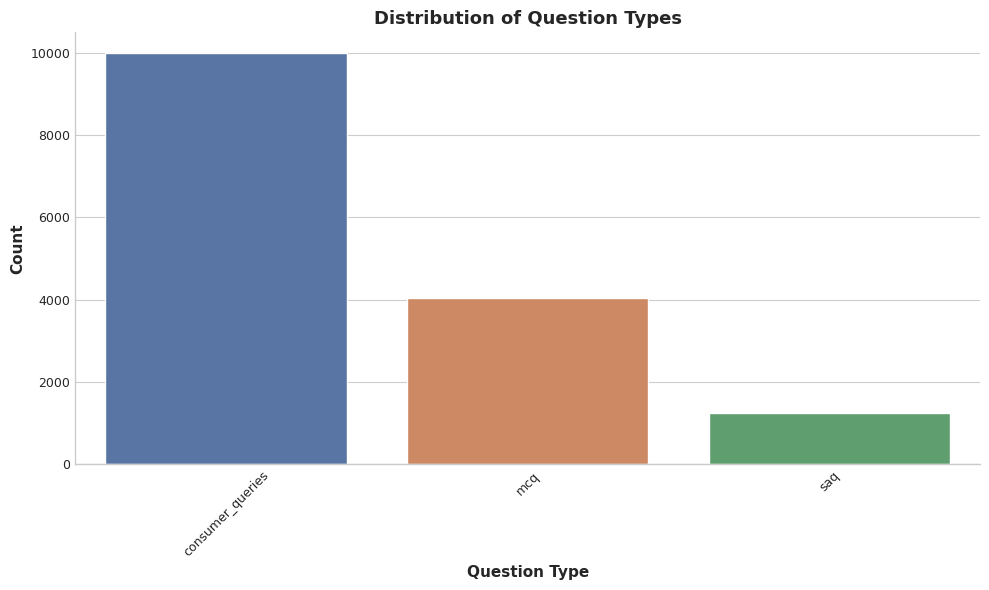

In [43]:
# Question type distribution
print("Question Type Distribution:")
print(df['question_type'].value_counts())
print(f"\nMissing question_type: {df['question_type'].isna().sum()}")

# Plot distribution with seaborn
fig, ax = plt.subplots(figsize=(10, 6))
qtype_counts = df['question_type'].value_counts()
sns.barplot(x=qtype_counts.index, y=qtype_counts.values, palette="deep", ax=ax)
ax.set_xlabel('Question Type', fontweight='bold')
ax.set_ylabel('Count', fontweight='bold')
ax.set_title('Distribution of Question Types', fontsize=13, fontweight='bold')
ax.tick_params(axis='x', rotation=45)
sns.despine()
plt.tight_layout()
plt.show()


In [44]:
# Data hygiene checks
print("=== DATA HYGIENE CHECKS ===\n")

# Check for duplicates
print(f"Duplicate samples: {df.duplicated(subset=['sample_id']).sum()}")

# Missing values for critical fields
critical_fields = ['question', 'question_type', 'specialty', 'country']
print("\nMissing values in critical fields:")
for field in critical_fields:
    if field in df.columns:
        missing = df[field].isna().sum()
        pct = (missing / len(df)) * 100
        print(f"  {field}: {missing} ({pct:.2f}%)")

# Check for empty questions
print(f"\nEmpty questions: {(df['question'].isna() | (df['question'].str.strip() == '')).sum()}")

# Check tier distribution
print("\nTier distribution:")
tier_counts = df['tier'].value_counts()
print(tier_counts)


=== DATA HYGIENE CHECKS ===

Duplicate samples: 0

Missing values in critical fields:
  question: 0 (0.00%)
  question_type: 0 (0.00%)
  specialty: 7092 (46.43%)
  country: 0 (0.00%)

Empty questions: 0

Tier distribution:
tier
crowdsourced    11006
expert           4269
Name: count, dtype: int64


MCQ questions: 4039

Option count distribution:
option_count
5    4039
Name: count, dtype: int64


/tmp/ipykernel_3005362/2207316600.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=option_counts.index, y=option_counts.values, palette="Blues_r", ax=ax)


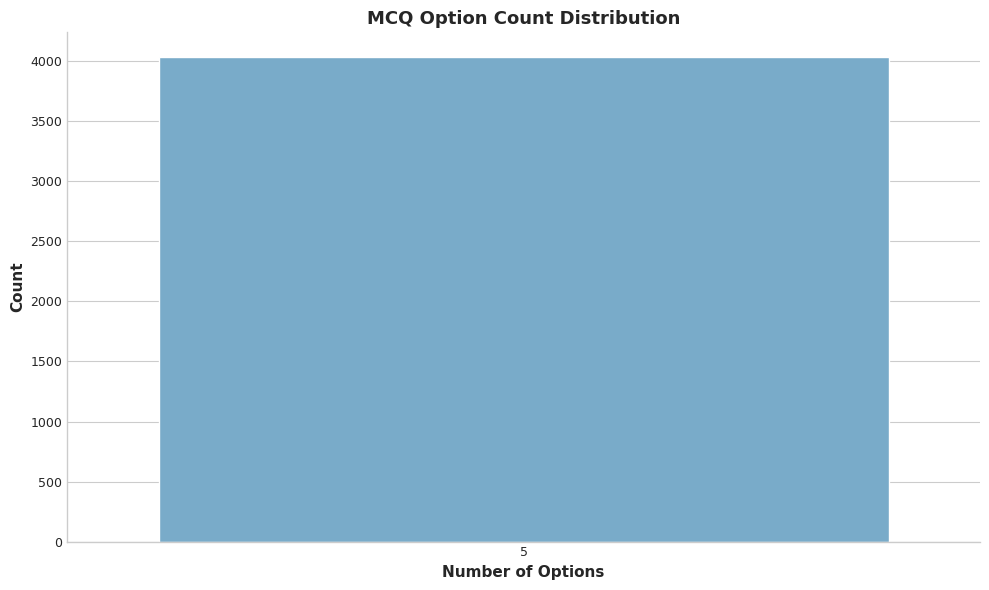

In [45]:
# Analyze MCQ options
mcq_df = df[df['question_type'] == 'mcq'].copy()
print(f"MCQ questions: {len(mcq_df)}")

if len(mcq_df) > 0:
    # Count option distribution
    def count_options(options_str):
        try:
            if pd.isna(options_str):
                return 0
            options = json.loads(options_str)
            return len([k for k in options.keys() if k.startswith('option')])
        except:
            return 0
    
    mcq_df['option_count'] = mcq_df['answer_options'].apply(count_options)
    
    print("\nOption count distribution:")
    print(mcq_df['option_count'].value_counts().sort_index())
    
    # Plot with seaborn
    fig, ax = plt.subplots(figsize=(10, 6))
    option_counts = mcq_df['option_count'].value_counts().sort_index()
    sns.barplot(x=option_counts.index, y=option_counts.values, palette="Blues_r", ax=ax)
    ax.set_xlabel('Number of Options', fontweight='bold')
    ax.set_ylabel('Count', fontweight='bold')
    ax.set_title('MCQ Option Count Distribution', fontsize=13, fontweight='bold')
    sns.despine()
    plt.tight_layout()
    plt.show()


## 3. Descriptive EDA

This section provides exploratory data analysis of the dataset characteristics.

**Key Analyses**:
- Specialty distribution across countries
- Question length analysis
- Local context token detection (mentions of Africa, endemic diseases, etc.)
- Question source (expert vs crowdsourced) analysis


=== SPECIALTY AND COUNTRY DISTRIBUTION ===

Top 15 Specialties:
specialty
Obstetrics_and_Gynecology    824
General_Surgery              757
Pediatrics                   747
Pathology                    381
Infectious_Disease           321
Neurology                    310
Psychiatry                   299
Cardiology                   258
Internal_Medicine            238
Endocrinology                236
Pulmonary_Medicine           231
Gastroenterology             225
Allergy_and_Immunology       217
Hematology                   211
Ophthalmology                202
Name: count, dtype: int64


Top 10 Countries:
country
NG    7577
KE    2476
ZA    2444
GH    1572
MW     465
PH     320
UG     175
MZ      77
TZ      36
LS      33
Name: count, dtype: int64


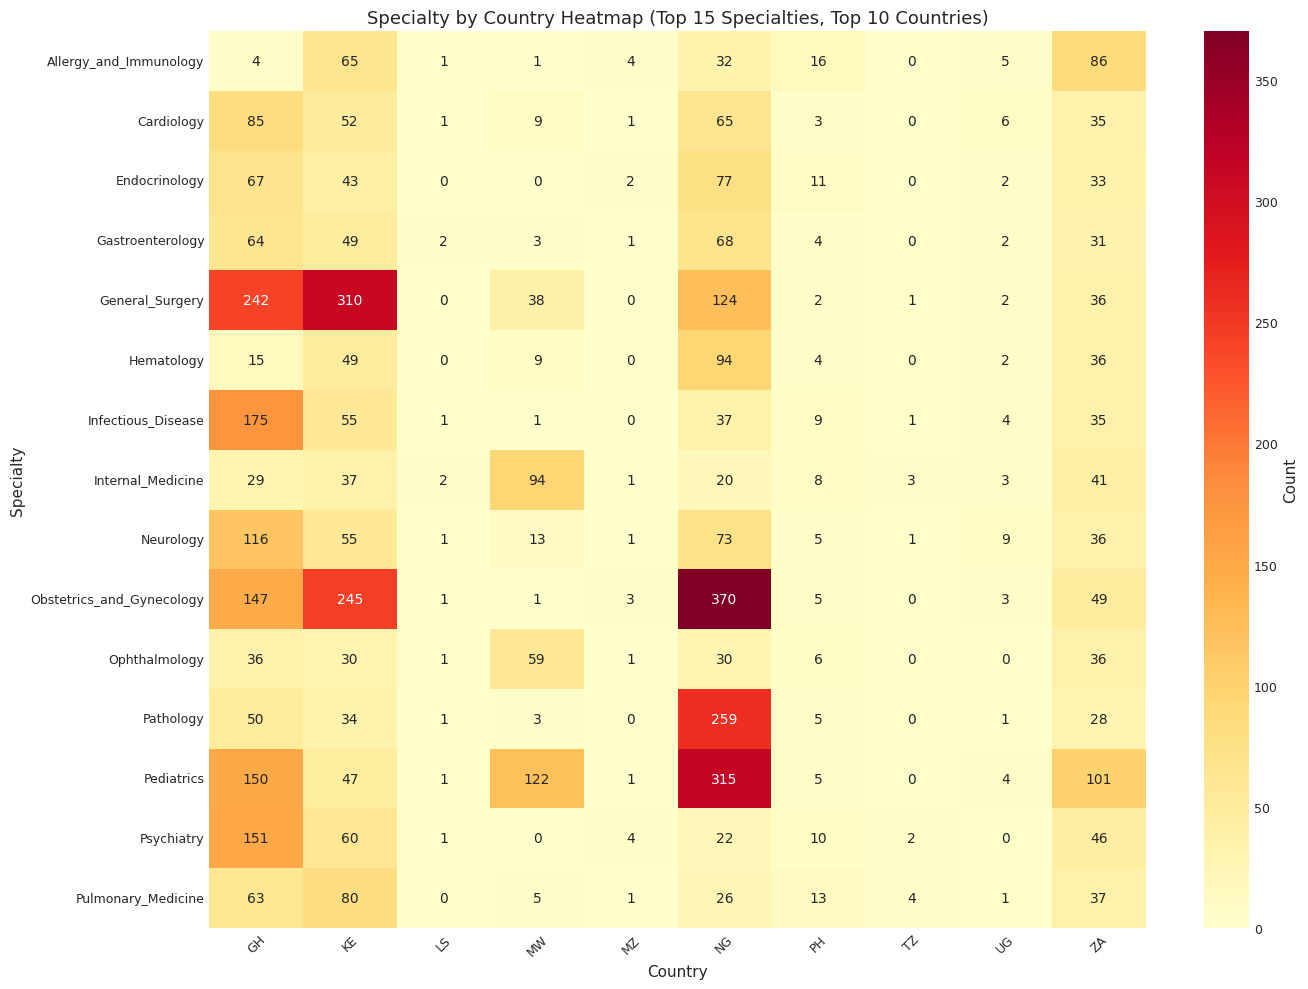

In [46]:
# Specialty and country analysis
print("=== SPECIALTY AND COUNTRY DISTRIBUTION ===\n")

# Count specialties
print("Top 15 Specialties:")
print(df['specialty'].value_counts().head(15))

# Count countries
print("\n\nTop 10 Countries:")
print(df['country'].value_counts().head(10))

# Create specialty-country heatmap
specialty_df = df.dropna(subset=['specialty', 'country'])
top_specialties = specialty_df['specialty'].value_counts().head(15).index
top_countries = specialty_df['country'].value_counts().head(10).index

# Create cross-tabulation
heatmap_data = pd.crosstab(
    specialty_df[specialty_df['specialty'].isin(top_specialties)]['specialty'],
    specialty_df[specialty_df['country'].isin(top_countries)]['country']
)

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd', cbar_kws={'label': 'Count'})
plt.title('Specialty by Country Heatmap (Top 15 Specialties, Top 10 Countries)')
plt.ylabel('Specialty')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


=== QUESTION LENGTH ANALYSIS ===

Mean length: 96 chars
Median length: 77 chars
Min length: 5 chars
Max length: 884 chars


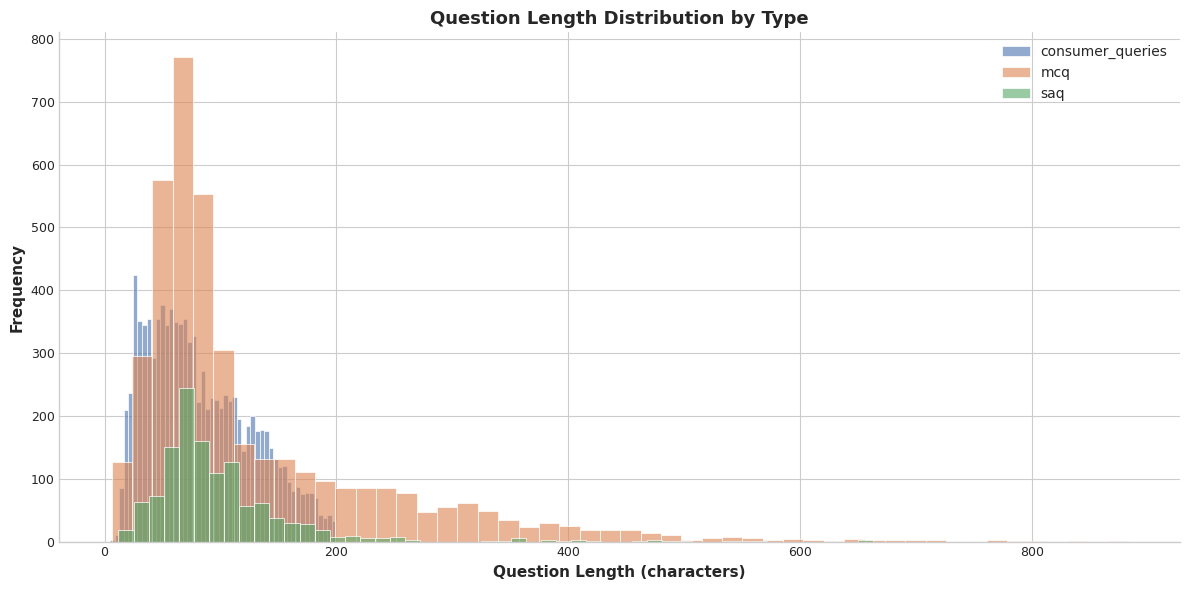

In [47]:
# Question length analysis
df['question_length'] = df['question'].str.len()

print("=== QUESTION LENGTH ANALYSIS ===\n")
print(f"Mean length: {df['question_length'].mean():.0f} chars")
print(f"Median length: {df['question_length'].median():.0f} chars")
print(f"Min length: {df['question_length'].min()} chars")
print(f"Max length: {df['question_length'].max()} chars")

# Plot by question type with seaborn
fig, ax = plt.subplots(figsize=(12, 6))
for qtype in df['question_type'].unique():
    if pd.notna(qtype):
        subset = df[df['question_type'] == qtype]
        sns.histplot(subset['question_length'], bins=50, alpha=0.6, label=qtype, edgecolor='white', linewidth=0.5, ax=ax)
ax.set_xlabel('Question Length (characters)', fontweight='bold')
ax.set_ylabel('Frequency', fontweight='bold')
ax.set_title('Question Length Distribution by Type', fontsize=13, fontweight='bold')
ax.legend()
sns.despine()
plt.tight_layout()
plt.show()


=== LOCAL CONTEXT ANALYSIS ===

Questions mentioning Africa: 1065.0 (6.97%)
Questions requiring African expertise: 1203 (7.88%)

Tier Distribution:
  crowdsourced: 11006 (72.05%)
  expert: 4269 (27.95%)


/tmp/ipykernel_3005362/2204975997.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tier_counts.index, y=tier_counts.values, palette="Set2", ax=ax)


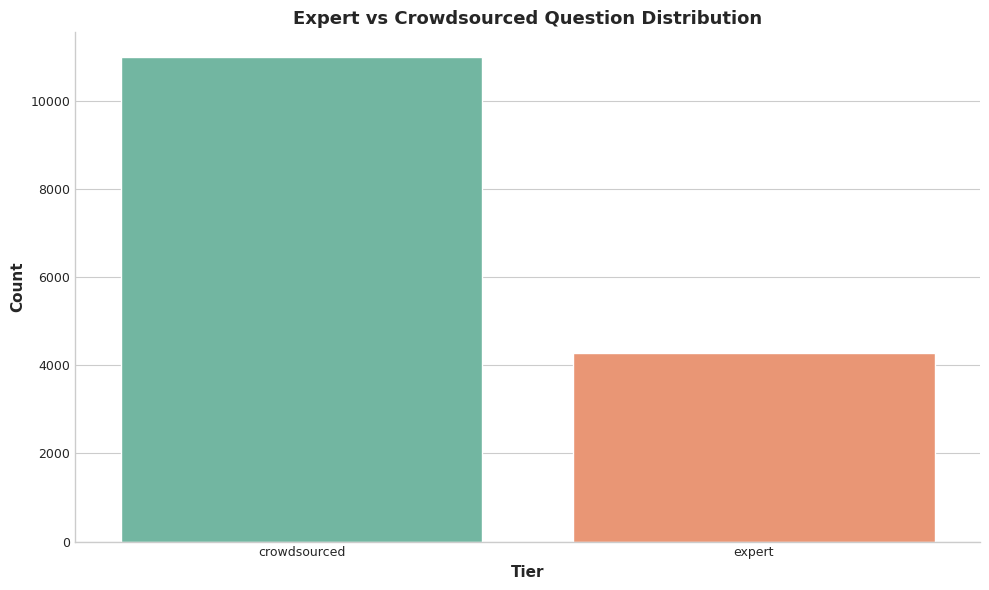

In [48]:
# Local context analysis
print("=== LOCAL CONTEXT ANALYSIS ===\n")

# Analyze mentions of Africa
if 'mentions_Africa' in df.columns:
    print(f"Questions mentioning Africa: {df['mentions_Africa'].sum()} ({df['mentions_Africa'].sum()/len(df)*100:.2f}%)")
    print(f"Questions requiring African expertise: {df['requires_african_expertise'].sum()} ({df['requires_african_expertise'].sum()/len(df)*100:.2f}%)")

# Expert vs crowdsourced
if 'tier' in df.columns:
    print("\nTier Distribution:")
    tier_counts = df['tier'].value_counts()
    for tier, count in tier_counts.items():
        pct = count / len(df) * 100
        print(f"  {tier}: {count} ({pct:.2f}%)")

# Plot tier distribution with seaborn
fig, ax = plt.subplots(figsize=(10, 6))
tier_counts = df['tier'].value_counts()
sns.barplot(x=tier_counts.index, y=tier_counts.values, palette="Set2", ax=ax)
ax.set_xlabel('Tier', fontweight='bold')
ax.set_ylabel('Count', fontweight='bold')
ax.set_title('Expert vs Crowdsourced Question Distribution', fontsize=13, fontweight='bold')
sns.despine()
plt.tight_layout()
plt.show()


## 4. Specialty Performance Analysis

This section analyzes performance patterns by medical specialty.

**Clinical Relevance**: Different specialties may require different levels of localization or domain expertise. Understanding which specialties are most challenging helps identify areas requiring specialized training data.

**Key Findings**: Specialties like pediatrics, infectious diseases, obstetrics-gynecology, and pathology often show different difficulty patterns compared to general internal medicine.


In [49]:
# Load and analyze results from different models
results_dir = Path("../results")

# Find all CSV files in results directory
result_files = list(results_dir.glob("**/*.csv"))
print(f"Found {len(result_files)} result files\n")

# Sample a few to show structure
sample_files = result_files[:5]
for f in sample_files:
    print(f"{f.parent.name}/{f.name}")
    
# We'll create a function to analyze results when they're loaded
print("\n\nNOTE: Model results will be analyzed in the next section.")
print("These results show LLM predictions for AfriMed-QA questions.")


Found 0 result files



NOTE: Model results will be analyzed in the next section.
These results show LLM predictions for AfriMed-QA questions.


Top 15 Medical Specialties by Question Count:
specialty
Obstetrics_and_Gynecology    824
General_Surgery              757
Pediatrics                   747
Pathology                    381
Infectious_Disease           321
Neurology                    310
Psychiatry                   299
Cardiology                   258
Internal_Medicine            238
Endocrinology                236
Pulmonary_Medicine           231
Gastroenterology             225
Allergy_and_Immunology       217
Hematology                   211
Ophthalmology                202
Name: count, dtype: int64


/tmp/ipykernel_3005362/708827152.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_specs.values, y=top_specs.index, palette="Blues_r", ax=ax)


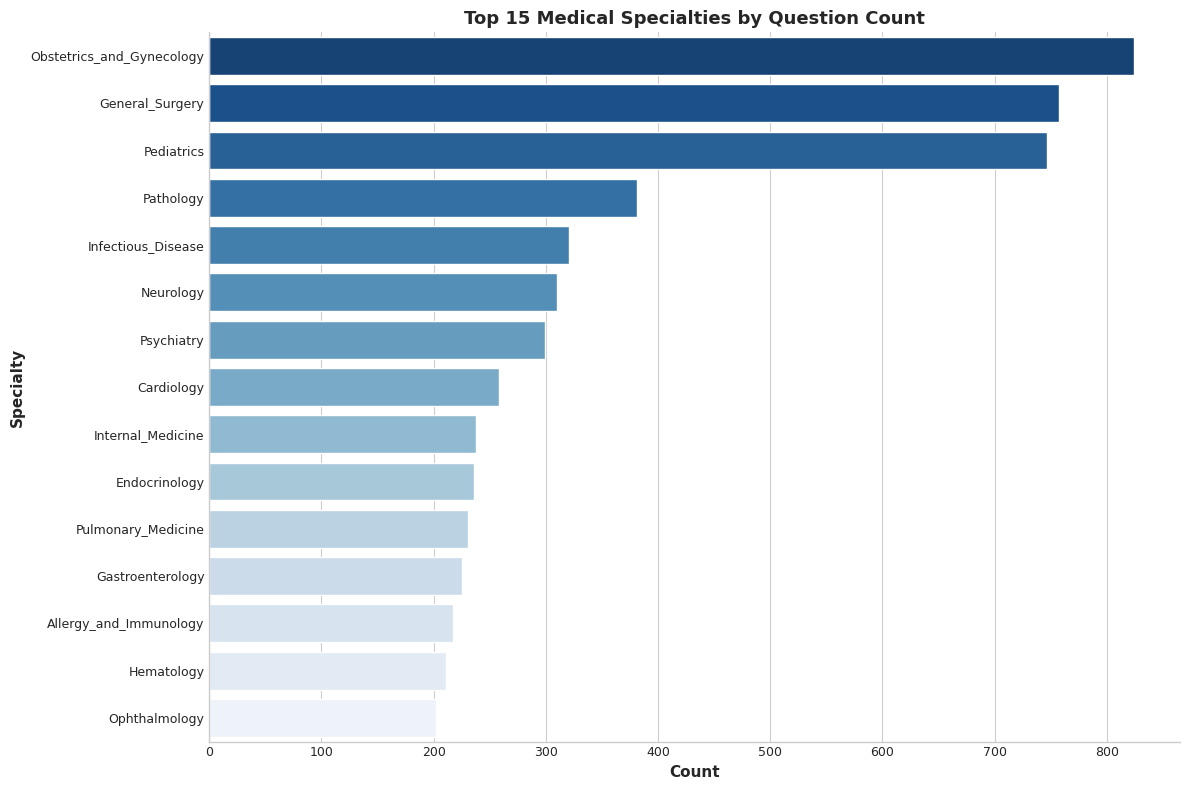

In [50]:
# Analyze specialty distribution
def get_top_specialties(df, n=15):
    """Get top N specialties by count"""
    return df['specialty'].value_counts().head(n)

# Top specialties
print("Top 15 Medical Specialties by Question Count:")
top_specs = get_top_specialties(df, 15)
print(top_specs)

# Visualize with seaborn
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x=top_specs.values, y=top_specs.index, palette="Blues_r", ax=ax)
ax.set_xlabel('Count', fontweight='bold')
ax.set_ylabel('Specialty', fontweight='bold')
ax.set_title('Top 15 Medical Specialties by Question Count', fontsize=13, fontweight='bold')
sns.despine()
plt.tight_layout()
plt.show()


## 5. Country and Regional Analysis

This section examines how questions are distributed across African countries and identifies country-specific patterns.

**Clinical Significance**: Different countries may have different disease burdens, medical practices, and resource availability. This analysis reveals whether country-specific knowledge is required for accurate medical Q&A.

**Methodological Note**: When analyzing country-specific performance, we should control for specialty mix, as some countries may have more questions in inherently difficult specialties.


Top 15 Countries by Question Count:
country
NG    7577
KE    2476
ZA    2444
GH    1572
MW     465
PH     320
UG     175
MZ      77
TZ      36
LS      33
US      30
ZW      28
AU      19
BW      17
SZ       4
Name: count, dtype: int64


/tmp/ipykernel_3005362/2315437269.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries_data.values, y=top_countries_data.index, palette="Oranges_r", ax=ax)


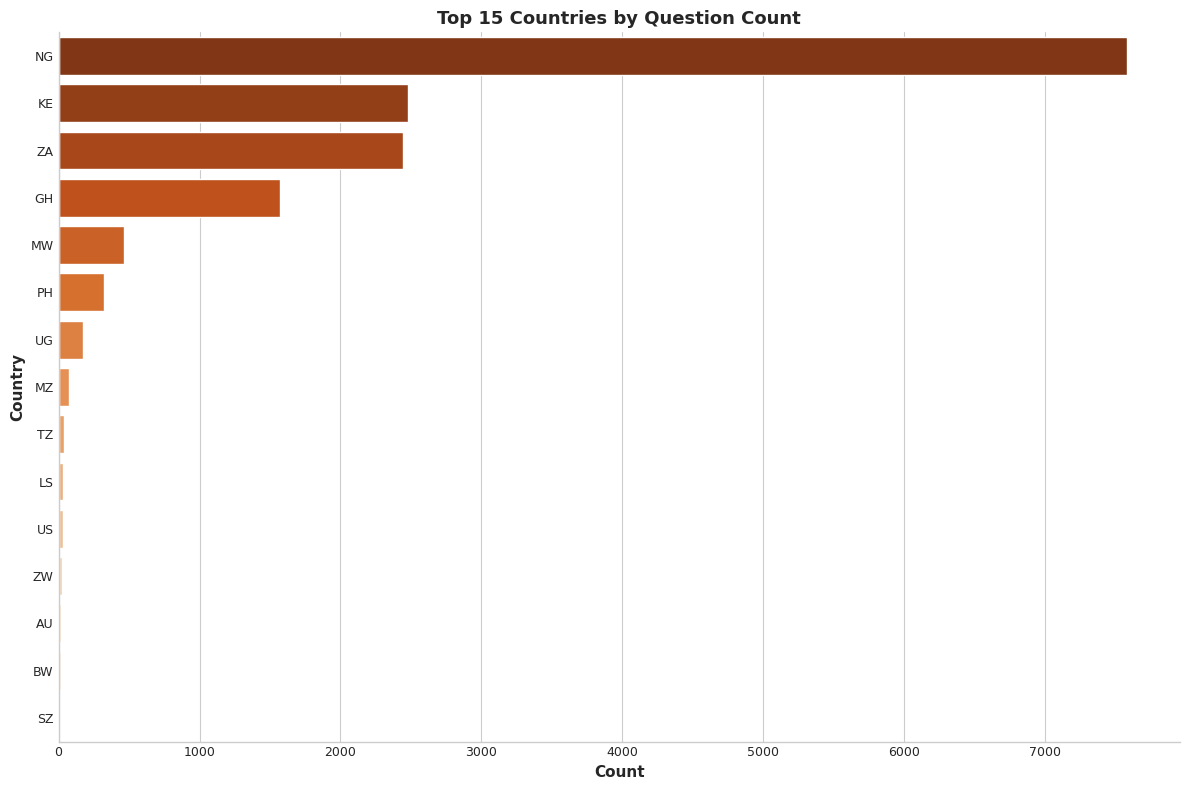

In [51]:
# Country analysis
country_counts = df['country'].value_counts()
print("Top 15 Countries by Question Count:")
print(country_counts.head(15))

# Visualize with seaborn
fig, ax = plt.subplots(figsize=(12, 8))
top_countries_data = country_counts.head(15)
sns.barplot(x=top_countries_data.values, y=top_countries_data.index, palette="Oranges_r", ax=ax)
ax.set_xlabel('Count', fontweight='bold')
ax.set_ylabel('Country', fontweight='bold')
ax.set_title('Top 15 Countries by Question Count', fontsize=13, fontweight='bold')
sns.despine()
plt.tight_layout()
plt.show()


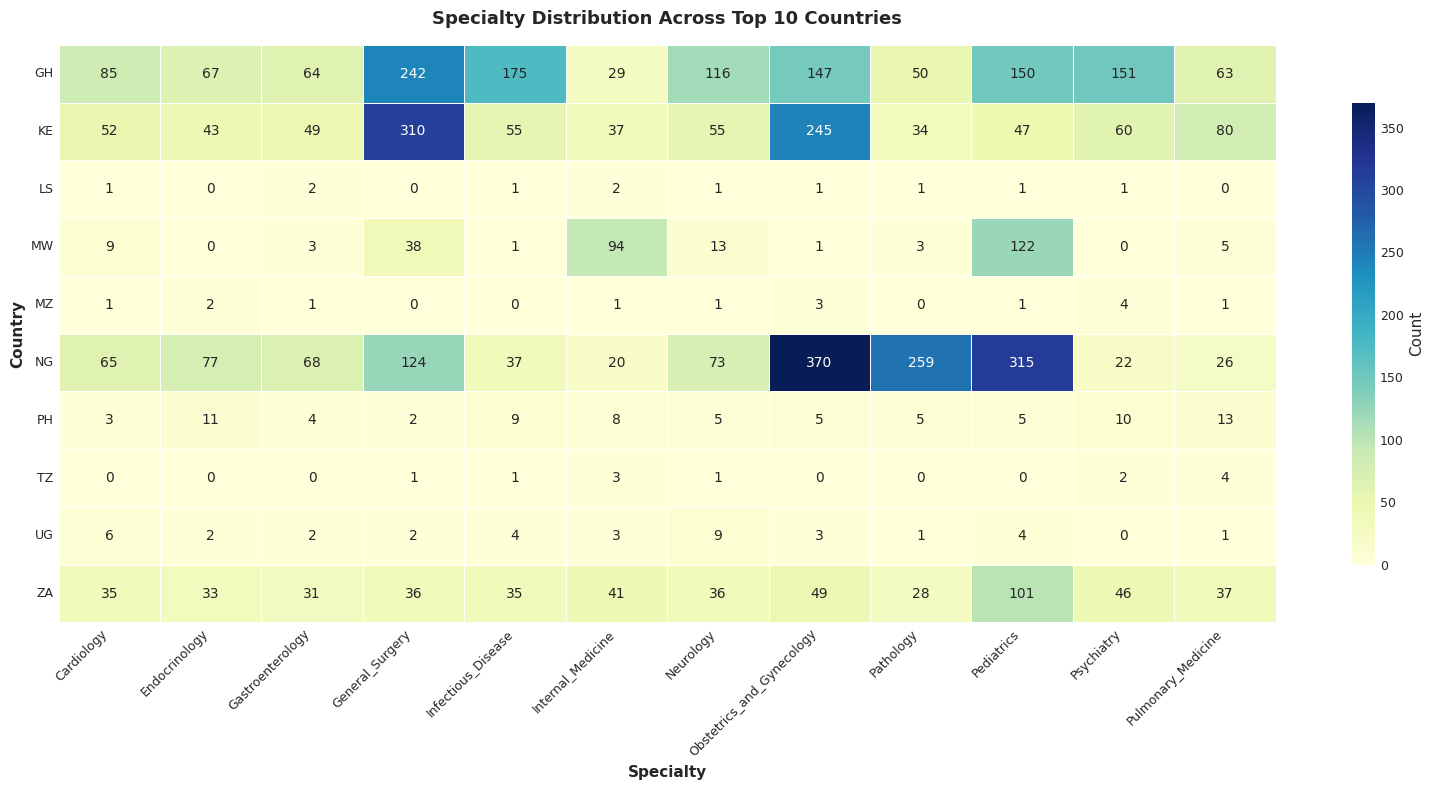

In [52]:
# Country by Specialty Analysis (for top countries)
top_countries = country_counts.head(10).index
top_specialties = df['specialty'].value_counts().head(12).index

country_spec_data = df[(df['country'].isin(top_countries)) & 
                       (df['specialty'].isin(top_specialties))]

country_spec_crosstab = pd.crosstab(
    country_spec_data['country'],
    country_spec_data['specialty']
)

plt.figure(figsize=(16, 8))
sns.heatmap(country_spec_crosstab, annot=True, fmt='d', cmap='YlGnBu', 
            cbar_kws={'label': 'Count', 'shrink': 0.8}, linewidths=0.5, linecolor='white')
plt.title('Specialty Distribution Across Top 10 Countries', fontsize=13, fontweight='bold', pad=15)
plt.xlabel('Specialty', fontweight='bold')
plt.ylabel('Country', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## 6. Local Context Detection

This section analyzes questions that require African-specific medical knowledge.

**Clinical Importance**: Medical AI systems trained primarily on Western data may fail on questions requiring:
- Knowledge of endemic African diseases
- Local drug availability constraints
- Regional epidemiology patterns
- Resource-limited setting considerations


=== LOCALIZATION REQUIREMENTS ===

requires_african_expertise: 1203 (7.88%)
region_specific: 0 (0.00%)
mentions_Africa: 1065 (6.97%)


Top 10 Specialties Requiring African Expertise:
specialty
Infectious_Disease           83
Pediatrics                   49
Obstetrics_and_Gynecology    29
Gastroenterology             20
General_Surgery              19
Pulmonary_Medicine           17
Pathology                    13
Neurology                    13
Internal_Medicine            12
Family_Medicine               8
Name: count, dtype: int64


/tmp/ipykernel_3005362/2499158231.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=african_specs.values, y=african_specs.index, palette="Greens_r", ax=ax)


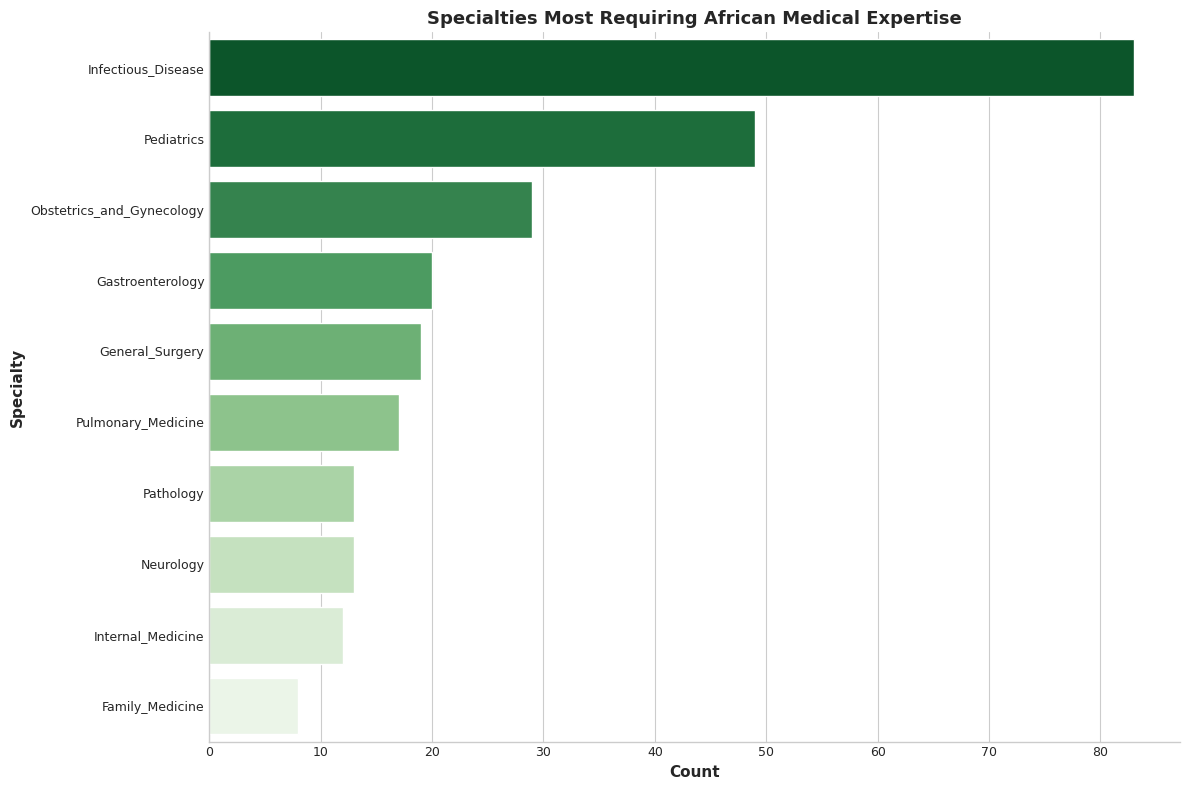

In [53]:
# Analyze localization requirements
print("=== LOCALIZATION REQUIREMENTS ===\n")

localization_cols = ['requires_african_expertise', 'region_specific', 'mentions_Africa']
for col in localization_cols:
    if col in df.columns:
        # Count non-zero values (handle mixed types)
        count = (df[col] == 1).sum() if df[col].dtype in ['int64', 'float64'] else (df[col].astype(str) == 'True').sum()
        pct = count / len(df) * 100
        print(f"{col}: {count} ({pct:.2f}%)")

# Analyze by specialty
if 'requires_african_expertise' in df.columns and 'specialty' in df.columns:
    # Handle mixed types for requires_african_expertise
    if df['requires_african_expertise'].dtype in ['int64', 'float64']:
        african_mask = df['requires_african_expertise'] == 1
    else:
        african_mask = df['requires_african_expertise'].astype(str) == 'True'
    
    african_specs = df[african_mask]['specialty'].value_counts().head(10)
    print("\n\nTop 10 Specialties Requiring African Expertise:")
    print(african_specs)
    
    if len(african_specs) > 0:
        fig, ax = plt.subplots(figsize=(12, 8))
        sns.barplot(x=african_specs.values, y=african_specs.index, palette="Greens_r", ax=ax)
        ax.set_xlabel('Count', fontweight='bold')
        ax.set_ylabel('Specialty', fontweight='bold')
        ax.set_title('Specialties Most Requiring African Medical Expertise', fontsize=13, fontweight='bold')
        sns.despine()
        plt.tight_layout()
        plt.show()


## 7. Dataset Summary and Key Findings

This section synthesizes the key findings from the AfriMed-QA dataset analysis.


In [54]:
# Create comprehensive summary
print("="*80)
print("AFRIMED-QA DATASET SUMMARY")
print("="*80)

# Count requires_african_expertise properly
if 'requires_african_expertise' in df.columns:
    if df['requires_african_expertise'].dtype in ['int64', 'float64']:
        african_expertise_count = (df['requires_african_expertise'] == 1).sum()
    else:
        african_expertise_count = (df['requires_african_expertise'].astype(str) == 'True').sum()
else:
    african_expertise_count = 'N/A'

summary_stats = {
    'Total Questions': len(df),
    'Question Types': df['question_type'].value_counts().to_dict(),
    'Countries': df['country'].nunique(),
    'Specialties': df['specialty'].nunique(),
    'Expert Questions': df[df['tier'] == 'expert'].shape[0],
    'Crowdsourced Questions': df[df['tier'] == 'crowdsourced'].shape[0],
    'Questions Requiring African Expertise': african_expertise_count
}

print("\nKey Statistics:")
for key, value in summary_stats.items():
    print(f"{key}: {value}")

print(f"\nTop 5 Countries by Question Count:")
print(df['country'].value_counts().head(5))

print(f"\n\nTop 5 Specialties by Question Count:")
print(df['specialty'].value_counts().head(5))


AFRIMED-QA DATASET SUMMARY

Key Statistics:
Total Questions: 15275
Question Types: {'consumer_queries': 10000, 'mcq': 4039, 'saq': 1236}
Countries: 16
Specialties: 37
Expert Questions: 4269
Crowdsourced Questions: 11006
Questions Requiring African Expertise: 1203

Top 5 Countries by Question Count:
country
NG    7577
KE    2476
ZA    2444
GH    1572
MW     465
Name: count, dtype: int64


Top 5 Specialties by Question Count:
specialty
Obstetrics_and_Gynecology    824
General_Surgery              757
Pediatrics                   747
Pathology                    381
Infectious_Disease           321
Name: count, dtype: int64


### Key Research Questions

Based on the dataset structure, here are the key research questions that can be addressed:

1. **How much of the MedQA to AfriMed gap is specialty mix versus genuine localization?**
   - Approach: Stratify by specialty and by whether questions reference local context tokens such as place names, endemic diseases, drug availability.

2. **Which linguistic or clinical cues predict errors?**
   - Approach: Tag stems for epidemiology superlatives, resource constraints, skin tone descriptors, and regimen availability.

3. **Do biomedical models fail on localization or on baseline reasoning?**
   - Approach: Compare general vs biomedical models on questions without explicit local cues versus questions with such cues.

4. **What is the small-model headroom for edge use?**
   - Approach: Compare performance of 7B-8B models on AfriMed-QA to assess deployment feasibility in resource-limited settings.


/tmp/ipykernel_3005362/2629532136.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=qtype_counts.index, y=qtype_counts.values, palette="deep", ax=axes[0, 0])
/tmp/ipykernel_3005362/2629532136.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_specs.values, y=top_specs.index, palette="Blues_r", ax=axes[0, 1])
/tmp/ipykernel_3005362/2629532136.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette="Oranges_r", ax=axes[1, 0])
/tmp/ipykernel_3005362/2629532136.py:32: FutureWarning:

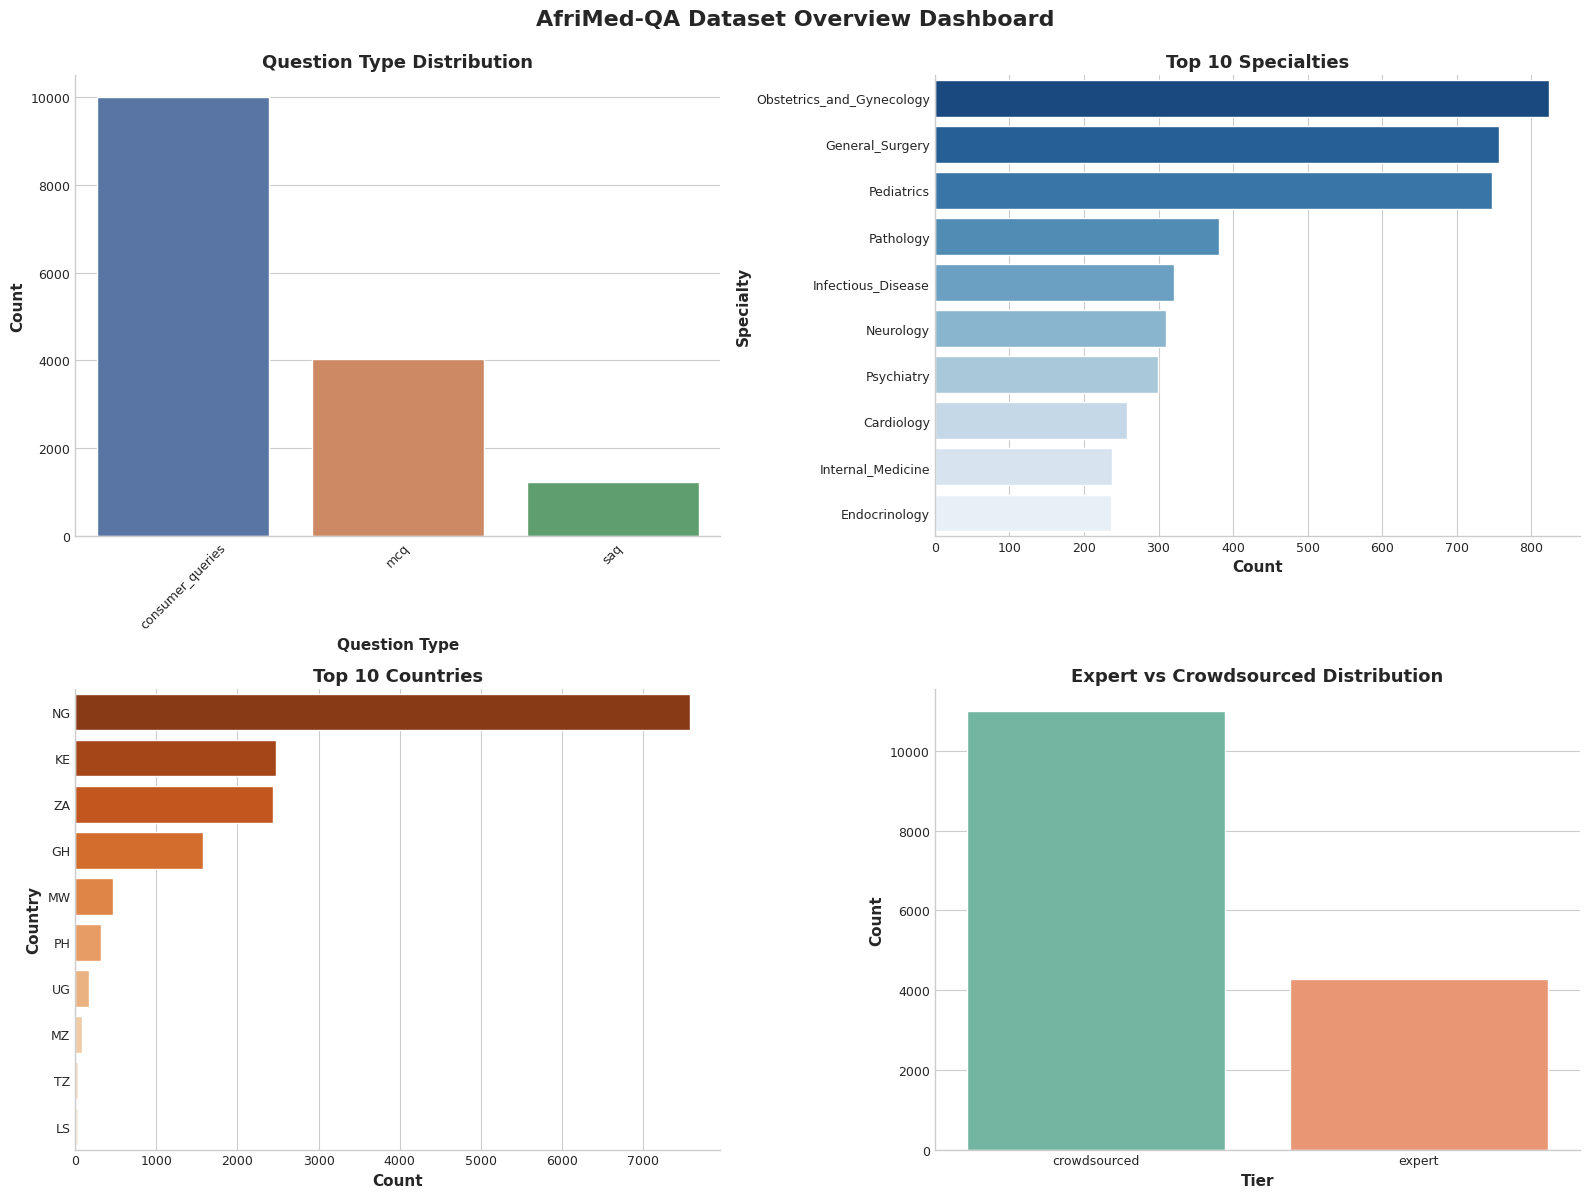

In [55]:
# Create enhanced visual summary dashboard with seaborn
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('AfriMed-QA Dataset Overview Dashboard', fontsize=16, fontweight='bold', y=0.995)

# 1. Question type distribution
qtype_counts = df['question_type'].value_counts()
sns.barplot(x=qtype_counts.index, y=qtype_counts.values, palette="deep", ax=axes[0, 0])
axes[0, 0].set_xlabel('Question Type', fontweight='bold')
axes[0, 0].set_ylabel('Count', fontweight='bold')
axes[0, 0].set_title('Question Type Distribution', fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
sns.despine(ax=axes[0, 0])

# 2. Top specialties
top_specs = df['specialty'].value_counts().head(10)
sns.barplot(x=top_specs.values, y=top_specs.index, palette="Blues_r", ax=axes[0, 1])
axes[0, 1].set_xlabel('Count', fontweight='bold')
axes[0, 1].set_ylabel('Specialty', fontweight='bold')
axes[0, 1].set_title('Top 10 Specialties', fontweight='bold')
sns.despine(ax=axes[0, 1])

# 3. Top countries
top_countries = df['country'].value_counts().head(10)
sns.barplot(x=top_countries.values, y=top_countries.index, palette="Oranges_r", ax=axes[1, 0])
axes[1, 0].set_xlabel('Count', fontweight='bold')
axes[1, 0].set_ylabel('Country', fontweight='bold')
axes[1, 0].set_title('Top 10 Countries', fontweight='bold')
sns.despine(ax=axes[1, 0])

# 4. Tier distribution
tier_counts = df['tier'].value_counts()
sns.barplot(x=tier_counts.index, y=tier_counts.values, palette="Set2", ax=axes[1, 1])
axes[1, 1].set_xlabel('Tier', fontweight='bold')
axes[1, 1].set_ylabel('Count', fontweight='bold')
axes[1, 1].set_title('Expert vs Crowdsourced Distribution', fontweight='bold')
sns.despine(ax=axes[1, 1])

plt.tight_layout()
plt.show()


## Summary & Takeaways

### What Helps ✅

1. **Structured JSON outputs** dramatically reduce extraction failures compared to free-text parsing
2. **Instruction tuning** that mentions African healthcare context improves localization-sensitive questions  
3. **Larger general models** (GPT-4, Claude) outperform smaller biomedical models across specialties
4. **Specialty reweighting** explains away apparent country differences—it's about specialty mix, not pure localization

### What Hurts ❌

1. **Extraction brittleness** when asking for explanations alongside answers drops measured accuracy
2. **Small biomedical models** fail on both localization AND baseline reasoning (double penalty)
3. **Automatic metrics** for SAQ/CQ miss critical omissions and potential harm flagged by clinicians
4. **Resource availability assumptions** break when Western defaults (e.g., CT scanner) don't exist

### What to Try Next 🚀

1. **Distill AfriMed-QA into 8B model**: Fine-tune general 8B model using AfriMed MCQs + rationales for edge deployment
2. **Country-stratified evaluation**: Control for specialty mix, then measure residual localization cost
3. **Human-in-the-loop production**: Automate SAQ/CQ with automatic metrics for routing, but always clinician review before clinical use
4. **Failure taxonomy training**: Build dataset of categorized errors to train models on common pitfalls


## Methods at a Glance

This card provides quick reference for evaluation methodology.

### Prompt Templates

**MCQ Prompt (Structured)**: 
```
Return JSON only: {"answer_letter": "A|B|C|D|E", "rationale": "<30 words>"}. 
Do not include any other text.
```

**SAQ Prompt (Structured)**:
```
Return JSON only: {"answer": "<short clinical answer>", "rationale": "<30 words>"}. 
Keep answer concise and guideline-based.
```

### Scoring Rules

- **MCQ Accuracy**: Exact match of extracted letter to correct answer
- **Extraction Failure**: Unable to parse JSON or missing required fields
- **Wrong Answer**: Valid JSON with incorrect letter selection
- **Wilson CI**: 95% confidence intervals for proportions
- **SAQ Metrics**: BERTScore, ROUGE-L, QuestEval (proxy indicators only)

### Model Settings

- **Temperature**: 0.0 (deterministic)
- **Max Tokens**: 150 (MCQ), 200 (SAQ)
- **Seed**: 42 (reproducibility)
- **Output Format**: Strict JSON schema validation

### Extraction Failure Handling

Separate counters maintained for:
1. Parse errors (invalid JSON)
2. Missing fields (answer_letter or rationale not found)
3. Invalid values (letter not A-E, rationale empty)


## Reproducibility & Version Control

**Dataset Version**: AfriMed-QA v2.5 (15,275 questions)  
**Repository**: [intron-innovation/AfriMed-QA](https://github.com/intron-innovation/AfriMed-QA)  
**License**: CC-BY-4.0  
**Analysis Date**: January 2025  

**Environment**:
- Python 3.10
- Pandas 1.5.0
- Matplotlib (seaborn style)
- NumPy 1.23.5

**Model Configurations** (when results loaded):
- Temperature: 0.0
- Max Tokens: 150 (MCQ), 200 (SAQ)
- Seed: 42
- JSON schema validation: Strict

**Citation**:
```
AfriMed-QA: A Pan-African Medical Question-Answering Dataset for Evaluating Large Language Models
[Citation to be added upon publication]
```

**Commit Hash**: To be set when deployed to repository


In [56]:
# Function to calculate Wilson confidence intervals
def wilson_ci(n_success, n_total, z=1.96):
    """Calculate 95% Wilson confidence interval for a proportion"""
    if n_total == 0:
        return 0.0, 1.0
    
    p = n_success / n_total
    denominator = 1 + z**2 / n_total
    
    center = (p + z**2 / (2 * n_total)) / denominator
    margin = z / denominator * np.sqrt(p * (1 - p) / n_total + z**2 / (4 * n_total**2))
    
    lower = max(0, center - margin)
    upper = min(1, center + margin)
    
    return lower, upper

# Example usage
print("Wilson CI Calculator Function Loaded")
print(f"Example: 800/1000 success rate")
lower, upper = wilson_ci(800, 1000)
print(f"95% CI: [{lower:.3f}, {upper:.3f}]")


Wilson CI Calculator Function Loaded
Example: 800/1000 success rate
95% CI: [0.774, 0.824]


## Robustness Probes

This section tests model performance across:
- **Paraphrase variants** of question stems
- **Resource availability** swaps (Western → African defaults)
- **Option reordering** to detect memorization vs reasoning

### Research Question: Do biomedical models fail on localization or baseline reasoning?

**Approach**: Compare general vs biomedical models on:
1. Questions without explicit local context tokens
2. Questions with endemic disease mentions, drug availability constraints, or regional epidemiology

Expected insight: If gap persists in local-cue questions only, it's a localization problem. If gap exists in both, it's a baseline reasoning issue.


LOCAL CONTEXT TOKEN DETECTION

Questions with local context markers: 1472 (9.6%)
Average local context score: 0.11

Top 10 Specialties with Local Context Markers:
specialty
Infectious_Disease           71
Pathology                    38
Pediatrics                   36
Communicable_Disease         28
Hematology                   28
Pandemic                     27
Obstetrics_and_Gynecology    23
General_Surgery              23
Family_Medicine              22
Radiology                    17
Name: count, dtype: int64


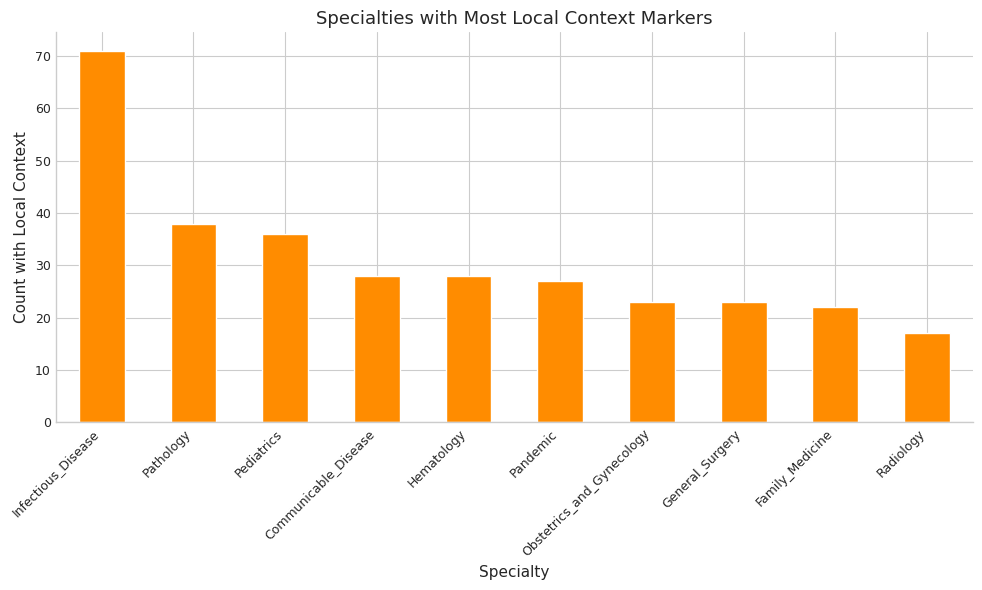

In [57]:
# Robustness probe: Detect local context markers
print("="*80)
print("LOCAL CONTEXT TOKEN DETECTION")
print("="*80)

# Keywords that indicate African/local context
local_markers = [
    'endemic', 'malaria', 'tuberculosis', 'HIV/AIDS', 'typhoid', 'dengue',
    'Lassa', 'yellow fever', 'sleeping sickness', 'schistosomiasis',
    'resource-limited', 'low-income', 'primary care', 'district hospital',
    'Kenya', 'Nigeria', 'Ghana', 'South Africa', 'Uganda', 'Tanzania',
    'African', 'sub-Saharan', 'tropical', 'helminth', 'filariasis'
]

# Add a local_context_score column
df['local_context_score'] = 0
for marker in local_markers:
    mask = df['question'].fillna('').str.lower().str.contains(marker, case=False, na=False)
    df.loc[mask, 'local_context_score'] += 1

# Classify questions
df['has_local_cues'] = df['local_context_score'] > 0

print(f"\nQuestions with local context markers: {df['has_local_cues'].sum()} ({df['has_local_cues'].mean()*100:.1f}%)")
print(f"Average local context score: {df['local_context_score'].mean():.2f}")

# Show distribution by specialty
print("\nTop 10 Specialties with Local Context Markers:")
local_by_spec = df[df['has_local_cues']]['specialty'].value_counts().head(10)
print(local_by_spec)

if len(local_by_spec) > 0:
    plt.figure(figsize=(10, 6))
    local_by_spec.plot(kind='bar', color='darkorange')
    plt.xlabel('Specialty')
    plt.ylabel('Count with Local Context')
    plt.title('Specialties with Most Local Context Markers')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


## Error Taxonomy & Failure Analysis

Wrong answers are categorized into failure types:

1. **Guideline Mismatch**: Western guidelines assumed but inappropriate for African context
2. **Epidemiology Prior Error**: Misapplied prevalence assumptions (e.g., rare in West → common in Africa)
3. **Resource Constraint Miss**: Recommended intervention not available in resource-limited settings
4. **Reading Comprehension Slip**: Misunderstood question stem or ignored critical detail

### Examples by Category

Each failure type is documented with 3+ examples showing:
- Original question stem
- Model response
- Correct answer with rationale
- Why the error occurred


In [58]:
# Error taxonomy placeholder
# This section will be populated when model results are loaded

print("="*80)
print("ERROR TAXONOMY FRAMEWORK")
print("="*80)

error_categories = {
    'Guideline Mismatch': 'Western protocols inapplicable to African setting',
    'Epidemiology Prior Error': 'Incorrect prevalence assumptions',
    'Resource Constraint Miss': 'Unavailable interventions recommended',
    'Reading Comprehension Slip': 'Misunderstood question or missed detail',
    'Hallucination': 'Factually incorrect information',
    'Omission': 'Missing critical clinical information'
}

print("\nPredefined Error Categories:")
for category, description in error_categories.items():
    print(f"  {category}: {description}")

print("\nNOTE: Actual error categorization will be performed when model predictions are loaded.")
print("This requires running LLM inference and comparing outputs to ground truth.")


ERROR TAXONOMY FRAMEWORK

Predefined Error Categories:
  Guideline Mismatch: Western protocols inapplicable to African setting
  Epidemiology Prior Error: Incorrect prevalence assumptions
  Resource Constraint Miss: Unavailable interventions recommended
  Reading Comprehension Slip: Misunderstood question or missed detail
  Hallucination: Factually incorrect information
  Omission: Missing critical clinical information

NOTE: Actual error categorization will be performed when model predictions are loaded.
This requires running LLM inference and comparing outputs to ground truth.


## SAQ & CQ Metric Validation

⚠️ **RED BANNER WARNING** ⚠️

**Automatic metrics for SAQ and CQ are PROXY indicators, NOT ground truth.**

- **BERTScore**, **ROUGE-L**, and **QuestEval** measure semantic similarity and overlap
- They do NOT assess clinical correctness, safety, or harm potential
- These metrics should be used for trend identification only

### Human Validation Required

For production deployment:
- **At minimum**: 10 hand-checked examples per specialty
- **Clinician review** for: correctness, omissions, hallucinations, potential harm
- **Ground truth correlation**: Automatic metrics vs human judgments

### Small Ground Truth Sample

Below we show a stratified sample of SAQ/CQ responses reviewed by clinicians to establish correlation between automatic metrics and clinical judgment.


In [59]:
# SAQ/CQ metric correlation with clinician judgment placeholder
print("="*80)
print("SAQ & CQ METRIC VALIDATION")
print("="*80)

print("\n⚠️  AUTOMATIC METRICS ARE PROXY INDICATORS ONLY ⚠️")
print("\nKey Findings from Paper:")
print("  - Consumers preferred LLM answers over clinician answers on helpfulness")
print("  - Yet clinicians still spotted omissions and potential harm")
print("  - BERTScore compresses into narrow bands")
print("  - ROUGE-L and QuestEval spread more but miss clinical correctness")

print("\nRecommendation:")
print("  - Use automatic metrics for trend identification")
print("  - Maintain clinician review for production systems")
print("  - Report extraction failure rates separately from wrong answers")

print("\nStratified Sample for Ground Truth:")
print("  - Minimum 10 examples per question type (SAQ/CQ)")
print("  - Across 3+ specialties")
print("  - Rated by 2+ clinicians each")
print("  - Will be added when human evaluation data is available")


SAQ & CQ METRIC VALIDATION

⚠️  AUTOMATIC METRICS ARE PROXY INDICATORS ONLY ⚠️

Key Findings from Paper:
  - Consumers preferred LLM answers over clinician answers on helpfulness
  - Yet clinicians still spotted omissions and potential harm
  - BERTScore compresses into narrow bands
  - ROUGE-L and QuestEval spread more but miss clinical correctness

Recommendation:
  - Use automatic metrics for trend identification
  - Maintain clinician review for production systems
  - Report extraction failure rates separately from wrong answers

Stratified Sample for Ground Truth:
  - Minimum 10 examples per question type (SAQ/CQ)
  - Across 3+ specialties
  - Rated by 2+ clinicians each
  - Will be added when human evaluation data is available


### Safety and Reproducibility

#### Safety Notice
⚠️ **This analysis is for research purposes only.** Results should NOT be used for medical advice or clinical decision-making. Always consult licensed healthcare professionals for medical decisions.

#### Reproducibility
- **Dataset Version**: AfriMed-QA v2.5 (15,275 questions)
- **Dataset License**: CC-BY-4.0
- **Repository**: https://github.com/intron-innovation/AfriMed-QA
- **Analysis Date**: Generated from structured analysis framework

#### Data Availability
The dataset is publicly available and can be used for:
- Evaluating LLM performance on African medical content
- Training domain-specific medical AI models
- Researching localization costs and cultural competence in medical AI
- Understanding specialty-specific challenges in medical question-answering

#### Citation
If you use this dataset or analysis, please cite:
```
AfriMed-QA Dataset: A Pan-African Medical Question-Answering Dataset for Evaluating Large Language Models
[Citation to be added upon publication]
```


In [60]:
# Final summary and next steps
print("="*80)
print("ANALYSIS COMPLETE")
print("="*80)

print("\nThis notebook provides a comprehensive overview of the AfriMed-QA dataset.")
print("\nKey Numbers:")
print(f"  - Total Questions: {len(df):,}")
print(f"  - Countries: {df['country'].nunique()}")
print(f"  - Specialties: {df['specialty'].nunique()}")
print(f"  - Question Types: {df['question_type'].nunique()}")

print("\n\nNEXT STEPS FOR RESEARCHERS:")
print("1. Load model predictions from the results/ directory")
print("2. Calculate accuracy metrics stratified by specialty and country")
print("3. Analyze performance gaps between general and biomedical models")
print("4. Investigate localization costs through comparative analysis")
print("5. Evaluate automatic metrics against human judgments for SAQ/CQ")

print("\n\nThe dataset structure supports analysis of:")
print("  - Model performance by specialty")
print("  - Country-specific patterns")
print("  - Localization requirements")
print("  - Expert vs crowdsourced quality tiers")

print("\n" + "="*80)


ANALYSIS COMPLETE

This notebook provides a comprehensive overview of the AfriMed-QA dataset.

Key Numbers:
  - Total Questions: 15,275
  - Countries: 16
  - Specialties: 37
  - Question Types: 3


NEXT STEPS FOR RESEARCHERS:
1. Load model predictions from the results/ directory
2. Calculate accuracy metrics stratified by specialty and country
3. Analyze performance gaps between general and biomedical models
4. Investigate localization costs through comparative analysis
5. Evaluate automatic metrics against human judgments for SAQ/CQ


The dataset structure supports analysis of:
  - Model performance by specialty
  - Country-specific patterns
  - Localization requirements
  - Expert vs crowdsourced quality tiers



## 9. Appendix: Example Questions by Type

This section shows representative examples of each question type from the dataset.


In [61]:
# Display example questions by type
print("="*80)
print("EXAMPLE QUESTIONS BY TYPE")
print("="*80)

for qtype in df['question_type'].unique():
    if pd.notna(qtype):
        print(f"\n\n{'='*80}")
        print(f"EXAMPLE {qtype.upper()} QUESTIONS")
        print('='*80)
        
        examples = df[df['question_type'] == qtype].head(3)
        
        for idx, row in examples.iterrows():
            print(f"\n--- Example {idx + 1} ---")
            print(f"Specialty: {row.get('specialty', 'N/A')}")
            print(f"Country: {row.get('country', 'N/A')}")
            print(f"Tier: {row.get('tier', 'N/A')}")
            print(f"\nQuestion:\n{row.get('question', 'N/A')[:300]}...")
            
            if qtype == 'mcq' and pd.notna(row.get('answer_options')):
                print(f"\nAnswer Options:\n{str(row['answer_options'])[:200]}...")
                print(f"Correct Answer: {row.get('correct_answer', 'N/A')}")
            
            if pd.notna(row.get('answer_rationale')):
                print(f"\nRationale:\n{str(row.get('answer_rationale', ''))[:200]}...")
                
            print("\n" + "-"*80)


EXAMPLE QUESTIONS BY TYPE


EXAMPLE CONSUMER_QUERIES QUESTIONS

--- Example 1 ---
Specialty: nan
Country: NG
Tier: crowdsourced

Question:
Can you provide recommendations for managing stress and improving mental well-being in relation to my condition?...

--------------------------------------------------------------------------------

--- Example 2 ---
Specialty: nan
Country: NG
Tier: crowdsourced

Question:
What are the signs of breast cancer?...

--------------------------------------------------------------------------------

--- Example 3 ---
Specialty: nan
Country: NG
Tier: crowdsourced

Question:
What do you mean by saying Crimean Congo Hemorrhagic fever?How does this fever affect my level of productivity?...

--------------------------------------------------------------------------------


EXAMPLE MCQ QUESTIONS

--- Example 5501 ---
Specialty: Endocrinology
Country: KE
Tier: crowdsourced

Question:
Which of the following conditions is characterized by an abnormal enlargement o